# Gift Recommender Engine: Reddit Data, Exploratory Data Analysis and Data Preprocessing

This notebook summarizes the steps I took to prepare the data for modelling. This involves exploratory data analysis, handling missing values, and cleaning text data.

## Import Libraries and Reddit Dataset

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
import spacy
%matplotlib inline

In [5]:
df = pd.read_csv('datasets/reddit-categories2.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

## Exploratory Data Analysis and Data Preprocessing

<b> Basic summary of the dataset! </b>

In [6]:
df.head()

,title,score,id,subreddit,url,num_comments,body,created,category
0,New r/tech discord server,10,nwb9yv,tech,https://www.reddit.com/r/tech/comments/nwb9yv/...,0,Unfortunately due to extreme circumstances the...,1.623287e+09,Electronics/Gadgets
1,Intel chief warns of two-year chip shortage,1842,otbino,tech,https://www.bbc.com/news/technology-57996908,199,NaN,1.627484e+09,Electronics/Gadgets
2,"New York, other states to fight dismissal of a...",429,otbgzp,tech,https://www.reuters.com/technology/new-york-ot...,6,NaN,1.627484e+09,Electronics/Gadgets
3,Microsoft's profits skyrocketed by 47 percent ...,695,ot3zze,tech,https://www.engadget.com/microsoft-q4-fy21-ear...,32,NaN,1.627452e+09,Electronics/Gadgets
4,Hiding malware inside AI neural networks,162,ot70z7,tech,https://techxplore.com/news/2021-07-malware-ai...,8,NaN,1.627467e+09,Electronics/Gadgets


In [10]:
print('Dataset columns: ', df.columns)
print('Size of dataset: ', df.shape)

Dataset columns:  Index(['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body',
       'created', 'category'],
      dtype='object')
Size of dataset:  (148037, 9)


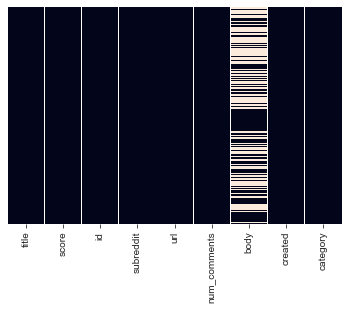

In [16]:
# Missing Values

sns.set_style('ticks')
sns.heatmap(df.isna(), cbar=False, yticklabels=False)
plt.show()

<b> How many posts are present in each category? </b> 

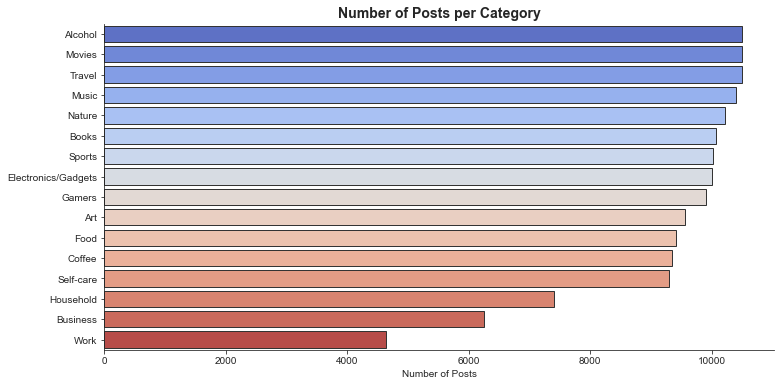

In [31]:
df_size = df.groupby('category').size().reset_index().rename(columns={0: 'size'}).sort_values('size', ascending=False)

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=df_size['size'], y=df_size['category'], palette='coolwarm', edgecolor='.2')
ax.set(xlabel='Number of Posts', ylabel='')
ax.set_title('Number of Posts per Category', fontweight='bold', fontsize=14)
sns.despine()
plt.show()

<b> What is the average score and total number of comments for the posts gathered in each category? </b>

In [39]:
df_score = df.groupby('category').agg({'score': 'mean'}).reset_index().sort_values('score', ascending=False)
df_comments = df.groupby('category').agg({'num_comments': 'sum'}).reset_index().sort_values('num_comments', ascending=False)

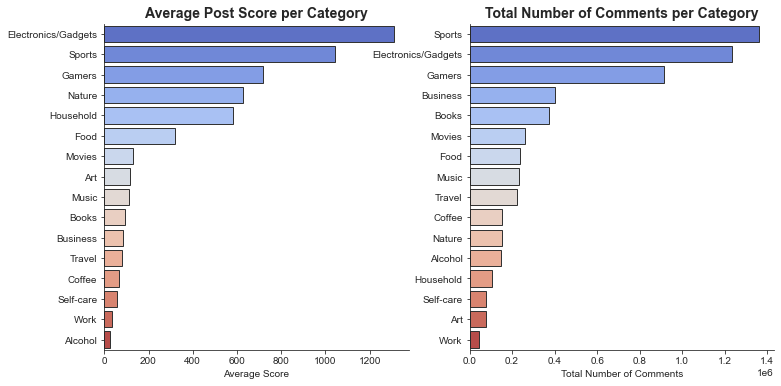

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

sns.barplot(x=df_score['score'], y=df_score['category'], palette='coolwarm', edgecolor='.2', ax=ax[0])
ax[0].set(xlabel='Average Score', ylabel='')
ax[0].set_title('Average Post Score per Category', fontsize=14, fontweight='bold')

sns.barplot(x=df_comments['num_comments'], y=df_comments['category'], palette='coolwarm', edgecolor='.2', ax=ax[1])
ax[1].set(xlabel='Total Number of Comments', ylabel='')
ax[1].set_title('Total Number of Comments per Category', fontsize=14, fontweight='bold')

sns.despine()
plt.show()

<b> Before proceeding further to analyzing review title and review body, I must preprocess the text data to first treat the missing values and clean them to obtain more useful findings. </b>

In [45]:
df.fillna('', inplace=True)
df.isna().sum()

title           0
score           0
id              0
subreddit       0
url             0
num_comments    0
body            0
created         0
category        0
dtype: int64

In [49]:
# Create a new column that combines the title and body, comprised of all the text data

df['all-text'] = df['title'] + ' ' + df['body']

0         New r/tech discord server Unfortunately due to...
1              Intel chief warns of two-year chip shortage 
2         New York, other states to fight dismissal of a...
3         Microsoft's profits skyrocketed by 47 percent ...
4                 Hiding malware inside AI neural networks 
                                ...                        
148032    Are IG influencers better than IG ads at the s...
148033    Lead generation  I just started my own company...
148034    How can I make money on the side with my skill...
148035    How do I reach customers while SEO is low?  He...
148036    Please roast my startup idea Hi reddit, I'm al...
Name: all-text, Length: 148037, dtype: object

In [143]:
#Function to lemmatize text using SpaCy

nlp = spacy.load('en_core_web_sm')

def spacy_lemmatize(text):
    if type(text) == list:
        doc = nlp(u"{}".format(' '.join(text)))
    else:
        doc = nlp(u"{}".format(text))
    lemmatized = list()
    for token in doc:
        lemmatized.append(token.lemma_)
    
    return lemmatized

In [176]:
#Preprocessing Function

punctuations = string.punctuation
stopwords = nltk.corpus.stopwords.words('english')

def preprocess(text):
    text = text.split() #split into list
    text = [re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE) for s in text] #remove any links
    text = [s.lower() for s in text] #convert every character into lowercase
    text = [re.sub(rf"[{string.punctuation}]", " ", s) for s in text] #remove punctuations
    text = [re.sub(r'[0-9]', ' ', s) for s in text] #remove all digits
    text = [s for s in text if s not in stopwords] #remove all stopwords
    text = ' '.join(text)  #resplits
    text = [s for s in text.split() if len(s) >= 2] #removes words with one word length
    text = ' '.join(spacy_lemmatize(text)) #lemmatize text using spacy and join into a string
    return text

In [188]:
# Clean Data - All
df['clean-text'] = df['all-text'].map(preprocess)

In [191]:
# Only data needed to train the model
#model_data = df[['category', 'clean-text']]

In [ ]:
# Save data to csv file
#df.to_csv('datasets/reddit-categories-clean2.csv')
#model_data.to_csv('datasets/train-test-data2.csv')